<a href="https://colab.research.google.com/github/JavierFernandezAcin/JavierFernandezAcin-DataScience-GenAI-Submissions/blob/main/BTC_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-777674964.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close = close.fillna(method='ffill')  # fill any NaNs
/tmp/ipython-input-777674964.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(SC[i]):
/tmp/ipython-input-777674964.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i - 1] + SC[i] * (close[i] - kama[i - 1])
/tmp/ipython-input-777674964.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always 

Date
2015-01-05 15:00:00+00:00    274.126266
2015-01-05 16:00:00+00:00    274.628975
2015-01-05 17:00:00+00:00    274.746322
2015-01-05 18:00:00+00:00    275.659068
2015-01-05 19:00:00+00:00    276.166149
2015-01-05 20:00:00+00:00    276.447860
2015-01-05 21:00:00+00:00    276.604367
2015-01-05 22:00:00+00:00    276.691315
2015-01-05 23:00:00+00:00    276.739619
2015-01-06 00:00:00+00:00    276.766455
dtype: float64
Number of missing prices: 0
Estimated κ = 0.1654
Dynamic entry threshold = 3.000

STRATEGY PERFORMANCE
Total Return:      -5.48%
Annualized Return: -0.52%
Volatility:        21.96%
Sharpe Ratio:      0.08
Max Drawdown:      44.17%
Number of Trades:  4840
Win Rate:          26.38%

Backtest results saved to 'btc_strategy_backtest.csv'


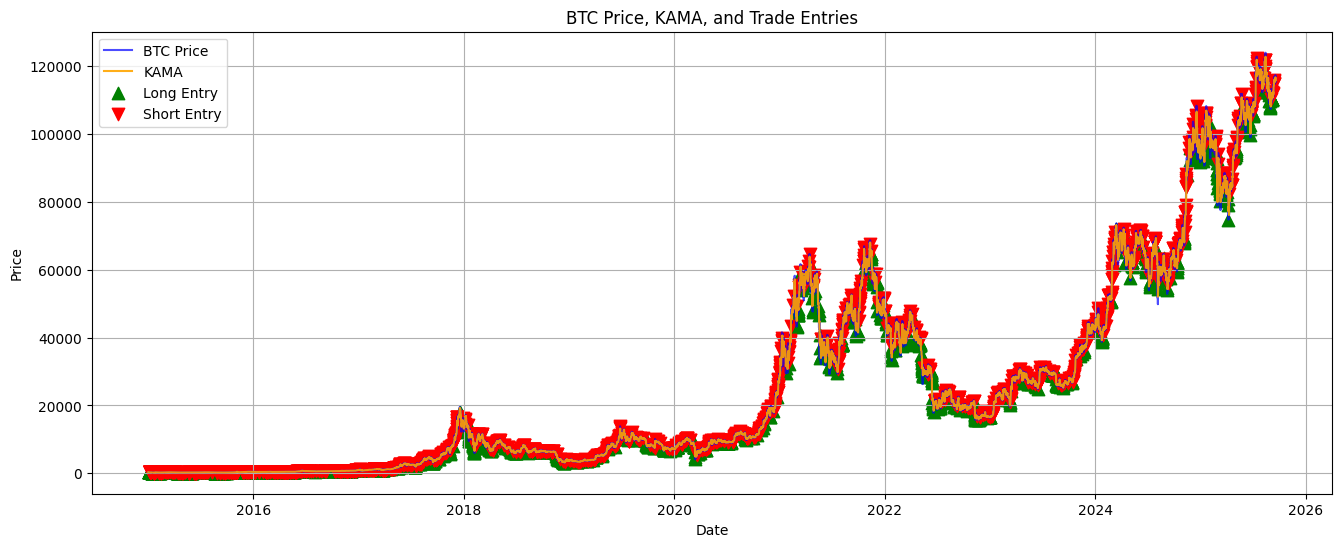

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PARAMETERS
C = 0   # round-trip transaction cost
R = 3      # risk margin
H = 5        # time horizon
KAMA_N = 10  # KAMA lookback period
FAST_SPAN = 2
SLOW_SPAN = 30
VOL_WINDOW = 20  # rolling window for volatility calculation

# LOAD DATA
df = pd.read_csv("/content/btc_1h_cleaned (2).csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)  # Use Date as the index
price = df['Close'].astype(float)

# KAMA
def KAMA(close, n=KAMA_N, fast=FAST_SPAN, slow=SLOW_SPAN):
    close = close.fillna(method='ffill')  # fill any NaNs
    ER = close.diff(n).abs() / close.diff().abs().rolling(n, min_periods=1).sum()
    fastSC = 2 / (fast + 1)
    slowSC = 2 / (slow + 1)
    SC = (ER * (fastSC - slowSC) + slowSC) ** 2

    kama = np.zeros(len(close))
    kama[:n] = close[:n]  # initialize first n values

    for i in range(n, len(close)):
        if np.isnan(SC[i]):
            SC[i] = SC[i - 1]  # carry forward previous smoothing constant
        kama[i] = kama[i - 1] + SC[i] * (close[i] - kama[i - 1])

    return pd.Series(kama, index=close.index)

price_kama = KAMA(price, n=KAMA_N, fast=FAST_SPAN, slow=SLOW_SPAN)
price_kama = pd.Series(price_kama, index=price.index)
print(price_kama.iloc[110:120])
num_missing = df['Close'].isna().sum()
print(f"Number of missing prices: {num_missing}")

# RESIDUALS AND Z-SCORE
residuals = price - price_kama
vol = residuals.rolling(VOL_WINDOW).std()  # vol = volatility
z_score = residuals / vol # z =(P - Mean) / volatility

# ESTIMATE MEAN-REVERSION SPEED (κ)
resid_clean = residuals.dropna()
phi = np.sum(resid_clean.values[1:] * resid_clean.values[:-1]) / np.sum(resid_clean.values[:-1] ** 2) # residual persistence
kappa = -np.log(phi) # speed of mean reversion
print(f"Estimated κ = {kappa:.4f}")

# DYNAMIC ENTRY THRESHOLD
threshold = (C / (1 - np.exp(-kappa * H))) + R # how far the price must deviate from the mean before we trade
print(f"Dynamic entry threshold = {threshold:.3f}")

# SIGNAL GENERATION
signals = pd.Series(0, index=price.index)
signals[z_score > threshold] = -1  # short
signals[z_score < -threshold] = 1  # long

# CLOSE POSITIONS ONLY WHEN Z-SCORE CHANGES SIGN
signals[z_score.shift(1) * z_score < 0] = 0

# BACKTEST
position = signals.shift(1).fillna(0)  # enter trades at next bar open
returns = price.pct_change().fillna(0)

strategy_ret = position * returns
strategy_ret -= C * (position.diff().abs() > 0).astype(int) * 0.5  # transaction cost per position change
equity = (1 + strategy_ret).cumprod()  # cumulative equity curve

# PERFORMANCE METRICS
total_return = equity.iloc[-1] - 1
annualized_return = (1 + total_return) ** (8760 / len(price)) - 1  # hourly data: 8760 hours/year
volatility = strategy_ret.std() * np.sqrt(8760)
sharpe = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(8760) if strategy_ret.std() != 0 else 0
max_dd = (1 - equity / equity.cummax()).max()

n_trades = (position.diff().abs() > 0).sum()
win_rate = np.nan
if n_trades > 0:
    trade_returns = strategy_ret[position.diff().abs() != 0]
    win_rate = (trade_returns > 0).mean()

print("\nSTRATEGY PERFORMANCE")
print(f"Total Return:      {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Volatility:        {volatility:.2%}")
print(f"Sharpe Ratio:      {sharpe:.2f}")
print(f"Max Drawdown:      {max_dd:.2%}")
print(f"Number of Trades:  {n_trades}")
print(f"Win Rate:          {win_rate:.2%}" if win_rate == win_rate else "Win Rate: N/A")

# SAVE RESULTS
df_out = pd.DataFrame({
    'price': price,
    'kama': price_kama,
    'residuals': residuals,
    'z_score': z_score,
    'signal': signals,
    'position': position,
    'strategy_ret': strategy_ret,
    'equity': equity
})

df_out.to_csv(r"BTC_results", index=False)
print("\nBacktest results saved to 'btc_strategy_backtest.csv'")

##EXTRA
long_entries = signals[signals == 1].dropna().index
short_entries = signals[signals == -1].dropna().index

# Plot
plt.figure(figsize=(16,6))
plt.plot(price.index, price, label='BTC Price', color='blue', alpha=0.7)
plt.plot(price_kama.index, price_kama, label='KAMA', color='orange', alpha=0.9)
plt.scatter(long_entries, price.loc[long_entries], marker='^', color='green', s=80, label='Long Entry')
plt.scatter(short_entries, price.loc[short_entries], marker='v', color='red', s=80, label='Short Entry')
plt.title('BTC Price, KAMA, and Trade Entries')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()